Useful stuff
---

In [1]:
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

Treat csv dataset
---

In [2]:
import os
import pandas as pd


dataset_dir = os.path.join(os.curdir, 'datasets', 'comments')

DEFAULT_COLUMNS = ["sentence", "class", "class_idx"]
dataset = AttributeDict(
    train=pd.DataFrame(columns=DEFAULT_COLUMNS),
    test=pd.DataFrame(columns=DEFAULT_COLUMNS)
)

classes = {
        "Donald Trump" : "Donald-Trump-%s.csv",
        "Joe Biden" : "Joe-Biden-%s.csv"
        }


for typ in dataset.keys():
    for class_idx, (class_name, class_path) in enumerate(classes.items()):
        df = pd.read_csv(os.path.join(dataset_dir, class_path%typ), index_col=0)
        df["class"] =  class_name
        df["class_idx"] = class_idx
        df.columns = DEFAULT_COLUMNS
        dataset[typ] = dataset[typ].append(df, ignore_index=True)

assert dataset.train.shape[1:] == (3,), "dataframe does not contain 3 columns named %s"%DEFAULT_COLUMNS
assert dataset.test.shape[1:] == (3,), "dataframe does not contain 3 columns named %s"%DEFAULT_COLUMNS

print(f'Number of words in our train dataset : {dataset.train.sentence.apply(lambda x : len(x.split(" "))).sum():.3e}')


Number of words in our train dataset : 7.084e+05


Preprocess all sentences
---
1. Change punctuation and normalize case
2. Replace all different name corresponding to a person with the same name
3. Apply preprocces_string from gensim with a custom filter

### Strip punctuation

In [3]:
import re
import nltk
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def clean_text(text):
    text = re.sub(r'\|\|\|', r' ', text)
    text = text.lower()
    return text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def make_docs(df_row):
    tokens = tokenize_text(df_row.sentence)
    doc = TaggedDocument(words=tokens, tags=df_row.index)
    return doc

# Apply clean text on both train and test dataset
for typ in ("train", "test"):
    dataset[typ].sentence = dataset[typ].sentence.parallel_apply(clean_text)

# Apply tokenize and Tagged Documents for both train and test dataset
for typ in ("train", "test"):
    dataset[typ]["doc"] = dataset[typ].parallel_apply(make_docs, axis=1)



INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Build the Doc2Vec model
---

In [6]:
from tqdm.notebook import tqdm
from multiprocessing import cpu_count

EMBEDDINGS_DIMS = 100
N_WORKERS = cpu_count()
MIN_COUNT = 2
WINDOW = 2
EPOCHS = 30
MODEL_NAME = f"doc2vec-dims_{EMBEDDINGS_DIMS}-min_count_{MIN_COUNT}-window_{WINDOW}-epochs_{EPOCHS}"

doc2vec_model = Doc2Vec(
    vector_size=EMBEDDINGS_DIMS,
    min_count=MIN_COUNT,
    workers=N_WORKERS,
    epochs=EPOCHS,
    compute_loss=True,
    )

doc2vec_model.build_vocab(dataset.train.doc.values)

In [5]:
from gensim.models.callbacks import CallbackAny2Vec, DiffMetric, ConvergenceMetric

class PlotLogger(CallbackAny2Vec):
    def __init__(self, model):
        self.p = tqdm(total=model.epochs)
        pass

    def on_epoch_end(self, model):
        self.p.update(1)
        # self.p.set_postfix_str(f"Loss {model.get_latest_training_loss():.3e}")

for epoch in range(10):
    doc2vec_model.train(dataset.train.doc.values,
                        total_examples=doc2vec_model.corpus_count,
                        epochs=doc2vec_model.epochs,
                        callbacks=[PlotLogger(doc2vec_model)]
                        )

In [16]:
models_path = os.path.join(os.curdir, 'models')
if not os.path.exists(models_path):
    os.mkdir(models_path)

doc2vec_model.save(os.path.join(models_path, MODEL_NAME+".model"))

TypeError: cannot pickle '_thread.lock' object

In [22]:

from sklearn.manifold import TSNE

vec_tsne = TSNE(n_components=2).fit_transform(doc2vec_model.wv.vectors)

/home/romaingrx/venv/linma2472/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/romaingrx/venv/linma2472/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/romaingrx/venv/linma2472/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128170 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/romaingrx/venv/linma2472/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/romaingrx/venv/linma2472/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/romaingrx/venv/linma2472/lib/pytho

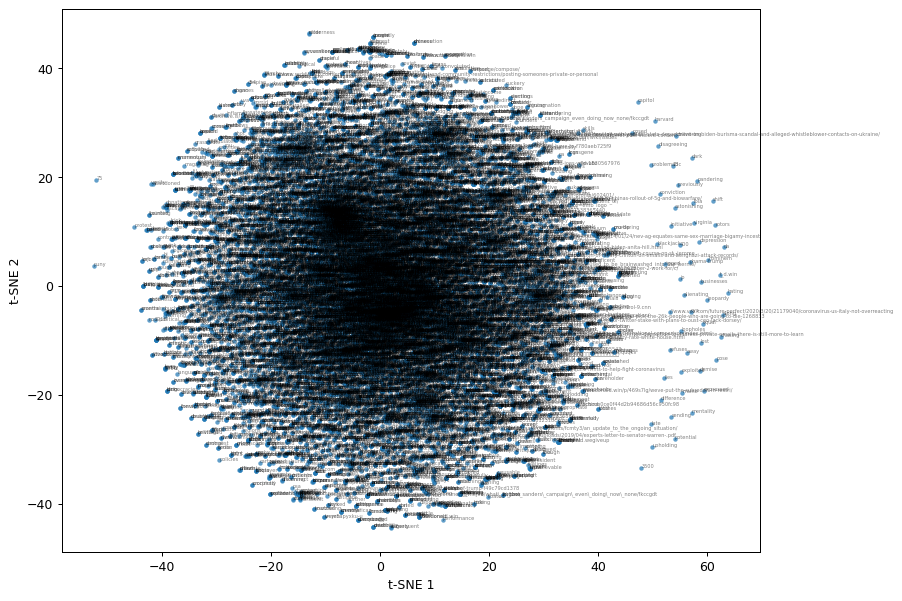

In [24]:
import matplotlib.pyplot as plt

vocabulary = list(doc2vec_model.wv.vocab)
# PLOT THE PROJECTION
fig = plt.figure(figsize = (10,8), dpi = 90)
plt.scatter(*zip(*vec_tsne), marker='.', s=50, lw=0, alpha=0.7,
                 edgecolor='k')

for i, (x,y) in enumerate(vec_tsne):
    plt.text(x,y, vocabulary[i],
                fontsize = 4, alpha = 0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [42]:
from bokeh.plotting import figure, output_notebook, show

plot_dict = AttributeDict(
    x = vec_tsne[:,0],
    y = vec_tsne[:,1],
    radius = [.75] * len(vec_tsne),

)
plot_dict.colors = [
        "#%02x%02x%02x"%(int(r), int(g), 150) for r, g in zip(10 + 2*abs(plot_dict.x), 10 + 2*abs(plot_dict.y))
    ]
output_notebook()

TOOLS = "crosshair,pan,wheel_zoom,box_zoom,reset,box_select,lasso_select"
p = figure(tools=TOOLS)

p.circle(x=plot_dict.x, y=plot_dict.y, radius=plot_dict.radius, fill_color=plot_dict.colors)
show(p)

Loading BokehJS ...

TODO:
- Preprocess et plot comme dans le [kaggle](https://www.kaggle.com/arthurtok/target-visualization-t-sne-and-doc2vec)
- plot en bokeh les words par dimensions et essayer de leur mettre la classe sur chaque
